## Testing the built Classes and Environment
-----

In [1]:
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

import src

In [2]:
# Initial State
from datetime import date
from astropy.time import Time
now = date.today()
time = Time(now.strftime(r'%Y-%m-%d %H:%M'), scale="utc")
walker_name = "mars"

walker_position, walker_velocity = src.get_body_state(walker_name, time).values()

#### Testing the `Walker` / `SunSystem` / `Solver` Composition
-----

In [3]:
system = src.SunSystem(["earth"]) # "jupiter"
walker = src.Walker(walker_position, walker_velocity, system, name=f"walker ({walker_name})")
solver = src.Solver()

In [4]:
for _ in range(600):
    walker.propagate(solver)
    system.propagate()

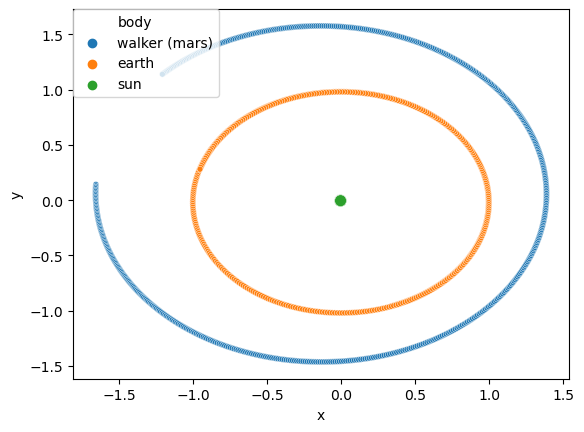

In [5]:
plotter = src.Plotter(walker=walker, system=system)
fig = plotter.draw(mode="2d")

#### Validating the `WalkerSystemEnv`

-----

In [6]:
from tf_agents.environments import validate_py_environment
from tf_agents.environments import tf_environment, tf_py_environment

In [7]:
system = src.SunSystem(["earth", "jupiter"])
walker = src.Walker(walker_position, walker_velocity, mass=1., name=f"walker ({walker_name})")
solver = src.Solver()
target = tf.constant([0., 0., 2.], dtype=tf.float32)

In [8]:
class Env(
    src.env.WalkerSystemEnv,
    src.env.DiscreteAction,
    src.env.AllPositionsObservation
): pass

In [9]:
env = Env(walker, system, solver, target, 
          max_iters=1000, max_boost=1e-4)
validate_py_environment(env, 2)

Demonstration of the usage of `src.tfpy_env_wrapper`:

In [10]:
tf_env_ = tf_py_environment.TFPyEnvironment(env)
print(isinstance(tf_env_, tf_environment.TFEnvironment))
print(hasattr(tf_env_, "walker"))

True
False


In [11]:
tf_env = src.env_wrappers.tfpy_env_wrapper(env)
print(isinstance(tf_env, tf_environment.TFEnvironment))
print(tf_env.walker)
print(tf_env.walker == walker)

True
True


Inspection of time and action specs:

In [12]:
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'system-positions': TensorSpec(shape=(3, 3), dtype=tf.float32, name='system-positions'),
                 'target': TensorSpec(shape=(3,), dtype=tf.float32, name='target'),
                 'walker-state': TensorSpec(shape=(6,), dtype=tf.float32, name='walker-state')},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='boost-direction', minimum=array(0), maximum=array(6))


#### Executing a Policy in the `WalkerSystemEnv`

In [13]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

time_step_spec = tf_env.time_step_spec()
action_spec    = tf_env.action_spec()

rand_tf_policy = RandomTFPolicy(
    time_step_spec=time_step_spec,
    action_spec=action_spec
)

In [14]:
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
driver = DynamicEpisodeDriver(
    tf_env,
    rand_tf_policy,
    num_episodes=1
)

For a default episode:

In [15]:
initial_time_step = tf_env.reset()
_ = driver.run()

In [16]:
plotter = src.Plotter(env=tf_env)
plotter.draw("3d")

For a given numer of steps:

In [17]:
time_step = tf_env.reset()
for _ in range(1000):
    # action = rand_tf_policy.action(time_step).action
    # action = tf.reshape(tf.constant([0., 0., 3e-5], tf.float32), (1, -1))
    action = 6
    time_step = tf_env.step(action)

If a custom `action` (a `tf.constant` in this case) is used, it has to has
shape $(1\times 3)$. There must be a "batch"-dimension when using 
`TFPyEnvironment`s.

In [18]:
plotter = src.Plotter(env = tf_env)
plotter.draw("3d")